In [220]:
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from quantum_logical import Pulse, DressedQuantumSystem
from quantum_logical.hamiltonian import QubitSNAILModule
from quantum_logical.mode import QubitMode, SNAILMode
from qutip import Options
from tqdm import tqdm

opts = {"nsteps": 1e6, "atol": 1e-8, "rtol": 1e-6}
p_bar = qt.ui.TextProgressBar()  # None

In [221]:
# Initial qubit frequencies and SNAIL frequency
# freqs = np.array([5.06167, 4.54944, 4.16829])  # q1, q2, q3 frequencies
# snail_freq = 4.27515  # SNAIL frequency

freqs = np.array([4.0, 6.0, 5.0])
snail_freq = 17.0 / 3

In [222]:
qubit_dim = 2
qubit1 = QubitMode(name="q1", dim=qubit_dim, freq=freqs[0])
qubit2 = QubitMode(name="q2", dim=qubit_dim, freq=freqs[1])
qubit3 = QubitMode(name="q3", dim=qubit_dim, freq=freqs[2])
qubits = [qubit1, qubit2, qubit3]
snail = SNAILMode(name="s", freq=snail_freq, g3=0.3, dim=10, T1=1e3, T2=5e2)

# define couplings so hybridizations are all equal
# g/delta = 0.1 for all qubits
g2_0 = 0.1 * np.abs(snail.freq - qubit1.freq)
g2_1 = 0.1 * np.abs(snail.freq - qubit2.freq)
g2_2 = 0.1 * np.abs(snail.freq - qubit3.freq)
_couplings = {
    frozenset([qubit1, snail]): g2_0,
    frozenset([qubit2, snail]): g2_1,
    frozenset([qubit3, snail]): g2_2,
}

qs = DressedQuantumSystem(
    qubits + [snail], couplings=_couplings, hamiltonian_cls=QubitSNAILModule
)

In [223]:
# create an initial state
# |0> \otimes |1> \otimes |0> \otimes |0>
psi0 = qs.prepare_approx_state([(qubit2, 1)])
rho0 = psi0 * psi0.dag()

Found overlap with eigenstate by 0.9946


In [224]:
# FIXME, main downside here is that we correctly want to define the action of
# the ancillae qubits as identity; but the action of the SNAIL should be undefined.
# This is because the action on SNAIL definitely won't be identity, but physically
# since SNAIL has short lifetime we know it will decay reliably to the ground state.
# However, our simulation doesn't necessarily include SNAIL loss channels. Therefore,
# the ideal action should be defined over the qubits only- not the SNAIL.

from qutip_qip.operations import iswap

desired_U = iswap()  # The iSWAP gate for a 2-qubit system

# Create isometries for qubit 1 and qubit 2 to extend the {g, e} subspace action to the full qubit space
identity_isometry = (
    qt.basis(qubit_dim, 0) * qt.basis(2, 0).dag()
    + qt.basis(qubit_dim, 1) * qt.basis(2, 1).dag()
)
identity_isometry = qt.tensor(identity_isometry, identity_isometry)

# Apply the isometry to extend the gate action to the complete system
extended_q1_q2 = identity_isometry * desired_U * identity_isometry.dag()

# Tensor with identity matrices for the remaining qubits and the SNAIL mode
# Skip the first two qubits as they're already included
# Skip the last index as it's the SNAIL mode
for mode in qs.modes[2:-1]:
    extended_q1_q2 = qt.tensor(extended_q1_q2, qt.qeye(mode.dim))

# The extended_iswap_q1_q2 now acts as the desired iSWAP gate on {g, e} of qubits 1 and 2, and as identity on the rest
desired_U = extended_q1_q2

# act on qubit space only
qubit_rho0 = rho0.ptrace(range(len(qubits)))
expected_qubit_rho = qt.Qobj(desired_U * qubit_rho0 * desired_U.dag())

In [225]:
# (undressed) expectation operators
e_ops = [qs.modes_num[m] for m in qs.modes]

# collapse operators
c_ops = []
# for mode in qs.modes:
#    c_ops.append(mode.collapse_operators(qs))

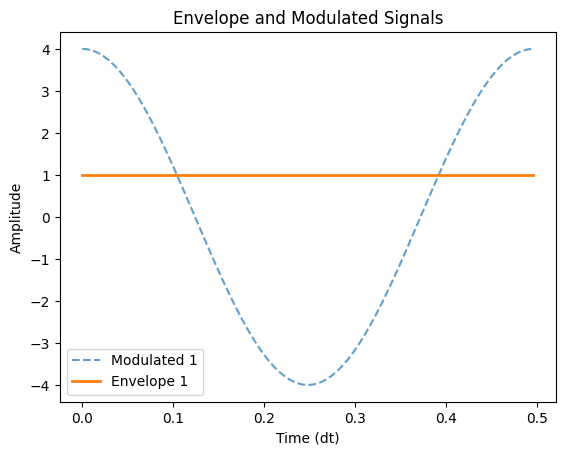

In [226]:
# Pulse preliminaries
wp = np.abs(qubit1.freq - qubit2.freq) + 0.1
T = 2 * np.pi / wp
period_time = np.linspace(0, T, 250)  # a single period of the pulse
args = {"shape": Pulse.constant}
pulse = Pulse(omega=wp, amp=4)
Pulse.plot_pulse([(pulse, args)], period_time)

In [233]:
# Step 1 is to determine maximum Pulse amplitude
# Can we use mesolve, sweep detuning and amplitude, output SNAIL population?
def simulation_task(freq_amp_pair):
    freq, amp = freq_amp_pair  # Unpack the tuple
    pulse = Pulse(omega=freq, amp=amp)
    H_pump = qs.hamiltonian.driven_term(snail_mode=snail, n_max=3.0)
    solve_result = qt.mesolve(
        H=[qs.hamiltonian.H0, [H_pump, pulse.drive]],
        rho0=rho0,
        tlist=period_time,
        e_ops=[qs.modes_num[snail]],
        args=args,
        options=opts,
    )
    return solve_result


# Define a 2D list of frequencies and amplitudes to sweep,
# frequencies will be detuned from the SNAIL's frequency
# amplitude from 0 to 10
N = 10
detuning_rads = 2 * np.pi * np.linspace(-0.1, 0.1, N)  # Detuning in rad/s
# flist = detuning_rads + snail.freq
qs._initialize_dressed_freqs()
flist = detuning_rads + wp
alist = np.linspace(0, 10, N)

# Prepare the parameters for parallel execution
freq_amp_pairs = [(f, a) for f in flist for a in alist]

# Run the simulations in parallel
results = qt.parallel.parallel_map(simulation_task, freq_amp_pairs, progress_bar=True)

# Process results
populations = np.array([r.expect[0] for r in results])

Total run time: 181.44s


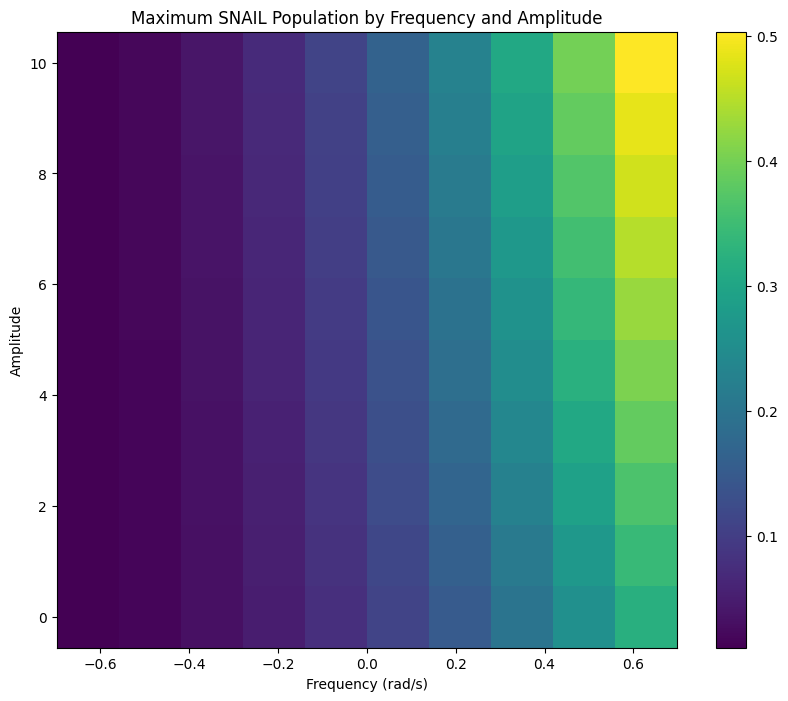

In [234]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming populations.shape is (100, 250) where there are 100 experiments and 250 time steps
# Compute the maximum population at each experiment
max_populations = np.max(populations, axis=1)

# Reshape the results into the shape of the amplitude and detuning grid
max_population_matrix = max_populations.reshape(N, N)

# Create meshgrid for the axes
freq_mesh, amp_mesh = np.meshgrid(detuning_rads, alist, indexing="ij")

# Plotting the heatmap
plt.figure(figsize=(10, 8))
heatmap = plt.pcolormesh(
    freq_mesh, amp_mesh, max_population_matrix.T, shading="auto", cmap="viridis"
)
plt.colorbar(heatmap)
plt.title("Maximum SNAIL Population by Frequency and Amplitude")
plt.xlabel("Frequency (rad/s)")
plt.ylabel("Amplitude")
plt.show()

In [89]:
# # Calculate the propagator for T
# # assumes Ampltiude * envelope(t) is real/constant

# # v1 integrate Pulse H1(t) = [c e^{-iwt} - c^* e^{iwt}] from 0 to T
# U_t = (-1j * (H0 * T + H1 * (2 * c * 1j * (np.cos(wp * T) - 1) / wp))).expm()

# v2 integate the Pulse H1(t) = c * cos(wp * t) from 0 to T
# U_t = (-1j * (H0 * T + H1 * (c * np.sin(wp * T) / wp))).expm()
# # Apply the propagator to the initial state
# rho_t = qt.Qobj(U_t * rho0 * U_t.dag())

# # Calculate fidelities
# best_fidelity = qt.fidelity(rho_t, expected_rho)
# avg_gate_fidelity = qt.average_gate_fidelity(desired_U, U_t)
# print(f"Best fidelity: {best_fidelity:.4f} with c = {c:.4f}")
# print(f"Average gate fidelity: {avg_gate_fidelity:.4f}")

#####################################
# try using qutip's propagator
# turns out to be the same as our manual integral calculation
period_time = np.linspace(0, T, 250)  # a single period of the pulse
pulse = Pulse(omega=wp, amp=c)
H = [H0, [H1, pulse.drive]]
U_ts = qt.propagator(H, period_time, c_ops, args=args, options=opts)

# plot occupations for each time step inside the period
period_occupations = {mode: np.zeros(len(period_time)) for mode in qs.modes_num}
for idx, t in enumerate(period_time):
    rho_tt = qt.Qobj(U_ts[idx] * dressed_rho * U_ts[idx].dag())
    for mode in qs.modes_num:
        period_occupations[mode][idx] = np.abs(qt.expect(qs.modes_num[mode], rho_tt))

# next, propagate the state 1 period at a time
U_t = U_ts[-1]  # propagator for T=1 period
full_time = np.linspace(0, 250 * T, 250)  # 250 periods of the pulse
occupations = {mode: np.zeros(len(full_time)) for mode in qs.modes_num}

rho_tt = dressed_rho
for idx, t in tqdm(enumerate(full_time)):
    rho_tt = qt.Qobj(U_t * rho_tt * U_t.dag())
    for mode in qs.modes_num:
        # cast to reals, but we expect the imaginary part to be zero
        occupations[mode][idx] = np.abs(qt.expect(qs.modes_num[mode], rho_tt))

250it [00:00, 2568.65it/s]


In [90]:
# what happens if I track the expectations values in the undressed basis?
# NOTE, converting back to this basis each iteration is 100+ times slower
und_occupations = {mode: np.zeros(len(full_time)) for mode in qs.modes_num}

rho_tt = dressed_rho
for idx, t in tqdm(enumerate(full_time)):
    rho_tt = qt.Qobj(U_t * rho_tt * U_t.dag())
    for mode in qs.modes_num:
        # before tracking, convert to the undressed basis
        und_rho_tt = convert_dressed_to_undressed(rho_tt)
        und_occupations[mode][idx] = np.abs(qt.expect(qs.modes_num[mode], und_rho_tt))

250it [00:15, 16.24it/s]


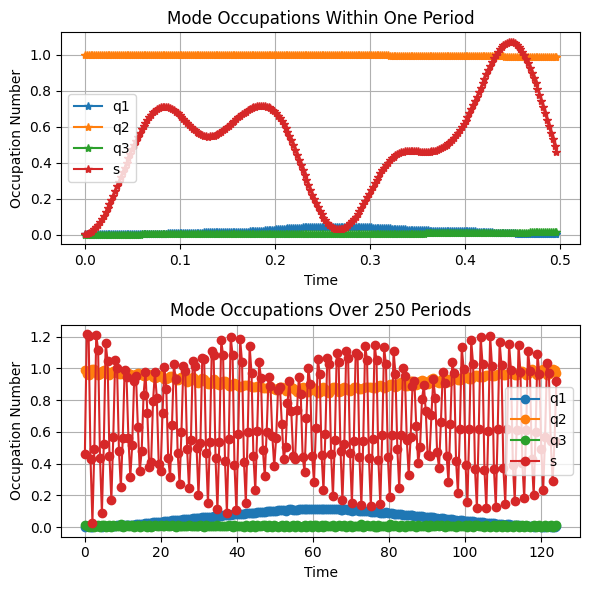

In [91]:
# Assuming qs.modes_num and other variables are already defined and calculated

# Setup the figure and axes for subplots
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

# Plotting fine-grained evolution within one period
for mode, occ in period_occupations.items():
    axs[0].plot(period_time, occ, label=mode.name, marker="*")
axs[0].set_title("Mode Occupations Within One Period")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Occupation Number")
axs[0].legend()
axs[0].grid(True)

# Plotting full time evolution over 20 periods
for mode, occ in occupations.items():
    axs[1].plot(full_time, occ, label=mode.name, marker="o")
    # axs[1].plot(
    #     full_time, und_occupations[mode], label=f"{mode.name} (und)", marker="."
    # )
axs[1].set_title("Mode Occupations Over 250 Periods")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Occupation Number")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()